# Irish Housing Market Trends and Dublin Price Forecast

## Step One: Data Preparation

### 1.1 Merge CSV Files

In [1]:
# pip install mysql-connector-python
# pip install pymysql
import pandas as pd 
from sqlalchemy import create_engine
import mysql.connector
import glob
import os

Data is downloaded from "Residential Property Price Regester" website. https://www.propertypriceregister.ie/

The maximal period length of housing information is from January 2010 to April 2024 (Register Last Updated:01/05/2024 17:48:16). Since only yearly data is available for download, Irish property register files need to be merged to one CSV file before uploading to database.

In [7]:
working_directory = os.getcwd()
joined_files = os.path.join(working_directory, 'PPR-*.csv')
joined_list = glob.glob(joined_files)  # A list of all csv files
joined_list.sort()

df = pd.concat(map(lambda x: pd.read_csv(x, encoding='unicode_escape'), joined_list), ignore_index=True)
# df.to_csv('1_merged_data.csv', index=False)

In [9]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,NaN,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,NaN,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,NaN,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",Meath,NaN,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,NaN,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [10]:
df.tail()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
658046,26/04/2024,"LISTELLICK NORTH, TRALEE, CO KERRY",Kerry,NaN,"280,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
658047,26/04/2024,"LONGFIELD, EDGEWORTHSTOWN, CO LONGFORD",Longford,N39D296,"290,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
658048,26/04/2024,"OLD ROAD, GRANGE, KILMALLOCK",Limerick,NaN,"172,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
658049,26/04/2024,"ST ANNES, COOLEGRANE, FOXFORD",Mayo,F26K820,"255,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
658050,26/04/2024,"THE PIKE, RATHCABBIN, ROSCREA",Tipperary,NaN,"240,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [17]:
df.shape

(658051, 9)

### 1.2 Store Merged CSV File in MySQL Database

In [2]:
hostname= "localhost"
database= "irish_property"
username= "root"
password= ".."

In [3]:
try:
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password=".."
    )
    print("Connection established")
    cursor = mydb.cursor()
    cursor.execute("create database if not exists irish_property")
    mydb.commit()
    print("Database created successfully")
    cursor.execute("use irish_property")

except mysql.connector.Error as err:
    print("An error occurred:", err)

Connection established
Database created successfully


In [4]:
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=database, user=username, pw=password))

In [14]:
# Save the merged csv file to MySQL database
df.to_sql('Irish_property_2010_2024', engine, if_exists='replace', index=False)

### 1.3 Retrieve File, Data Wrangling and Save Cleaned Data Back to Database

In [20]:
# Retrieve the file from the MySQL databse
df = pd.read_sql('SELECT * from Irish_property_2010_2024', con=engine)

In [21]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,None,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,None
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,None,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,None,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,None
3,04/01/2010,"1 The Haven, Mornington",Meath,None,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,None
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,None,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,None


In [23]:
df.shape

(658051, 9)

#### Data Wrangling

In [25]:
# Understand the data
print('The size of the data is:', '\n', df.shape)
# print(df.head())
print('\nCheck Null Values:', '\n', df.isnull().sum())
print('\nCheck Data Types:', '\n', df.dtypes)

print('Columns are: ', df.columns)
columns_check = ['County', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description']
for column in columns_check:
    print(df[column].value_counts())
    print()

The size of the data is: 
 (658051, 9)

Check Null Values: 
 Date of Sale (dd/mm/yyyy)         0
Address                           0
County                            0
Eircode                      519271
Price ()                         0
Not Full Market Price             0
VAT Exclusive                     0
Description of Property           0
Property Size Description    605226
dtype: int64

Check Data Types: 
 Date of Sale (dd/mm/yyyy)    object
Address                      object
County                       object
Eircode                      object
Price ()                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object
Columns are:  Index(['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Eircode',
       'Price ()', 'Not Full Market Price', 'VAT Exclusive',
       'Description of Property', 'Property Size Description'],
      dtype='object')
Dublin       

In [26]:
# Convert data type of the column 'Date of Sale (dd/mm/yyyy)' from 'object' to 'datetime', and change the column name accordingly.
df['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df['Date of Sale (dd/mm/yyyy)'], dayfirst=True)
df.rename(columns={'Date of Sale (dd/mm/yyyy)': 'Date of Sale (yyyy-mm-dd)'}, inplace=True)

In [27]:
# Rename 'Price ()' to 'Price (Euro)', as the symbol does not appear properly in csv file
df.rename(columns={'Price ()': 'Price (Euro)'}, inplace=True)
# The price is shown as '\x80343,000.00', use str.lstrip() method to strip the '\x80' characters from the beginning of each string:
df['Price (Euro)'] = df['Price (Euro)'].str.lstrip('\x80')
df['Price (Euro)'] = df['Price (Euro)'].str.replace(',', '')    # remove ','
df[['Price (Euro)']] = df[['Price (Euro)']].astype("float")     # convert to float
print(df[['Price (Euro)']].head())

   Price (Euro)
0      343000.0
1      185000.0
2      438500.0
3      400000.0
4      160000.0


In [28]:
# Standardize Column "Description of Property"
property_description_catogories = list(df['Description of Property'].unique())
for i, catogory in enumerate(property_description_catogories):
    print(i, catogory)

0 Second-Hand Dwelling house /Apartment
1 New Dwelling house /Apartment
2 Teach/Árasán Cónaithe Atháimhe
3 Teach/Árasán Cónaithe Nua
4 Teach/?ras?n C?naithe Nua


In [29]:
# Replace Irish Sentences with English
# Replace "Teach/Árasán Cónaithe Nua" with "New Dwelling house /Apartment"
df['Description of Property'].replace(property_description_catogories[3], property_description_catogories[1], inplace=True)
# Replace "Teach/?ras?n C?naithe Nua" with "New Dwelling house /Apartment"
df['Description of Property'].replace(property_description_catogories[4], property_description_catogories[1], inplace=True)
# Replace "Teach/Árasán Cónaithe Atháimhe" with "Second-Hand Dwelling house /Apartment"
df['Description of Property'].replace(property_description_catogories[2], property_description_catogories[0], inplace=True)

In [30]:
# Standardize Column "Property Size Description"
property_size_catagories = list(df['Property Size Description'].unique())
for i, catogory in enumerate(property_size_catagories):
    print(i, catogory)

# Replace "n?os l? n? 38 m?adar cearnach" with "less than 38 sq metres"
df['Property Size Description'].replace(property_size_catagories[6], property_size_catagories[3], inplace=True)
# Replace "níos mó ná nó cothrom le 38 méadar cearnach agus níos lú ná 125 méadar cearnach" with "greater than or equal to 38 sq metres and less than 125 sq metres"
df['Property Size Description'].replace(property_size_catagories[5], property_size_catagories[1], inplace=True)
# Replace "greater than 125 sq metres" with "greater than or equal to 125 sq metres"
df['Property Size Description'].replace(property_size_catagories[2], property_size_catagories[4], inplace=True)

0 None
1 greater than or equal to 38 sq metres and less than 125 sq metres
2 greater than 125 sq metres
3 less than 38 sq metres
4 greater than or equal to 125 sq metres
5 níos mó ná nó cothrom le 38 méadar cearnach agus níos lú ná 125 méadar cearnach
6 n?os l? n? 38 m?adar cearnach


In [32]:
df.head()

,Date of Sale (yyyy-mm-dd),Address,County,Eircode,Price (Euro),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,None,343000.0,No,No,Second-Hand Dwelling house /Apartment,None
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,None,185000.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,None,438500.0,No,No,Second-Hand Dwelling house /Apartment,None
3,2010-01-04,"1 The Haven, Mornington",Meath,None,400000.0,No,No,Second-Hand Dwelling house /Apartment,None
4,2010-01-04,"11 Melville Heights, Kilkenny",Kilkenny,None,160000.0,No,No,Second-Hand Dwelling house /Apartment,None


In [33]:
print('After Data Wrangling:')
# print(df.head())
print('\nCheck Data Types:', '\n', df.dtypes)
# columns_check = ['County', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description']
for column in columns_check:
    print(df[column].value_counts())
    print()

After Data Wrangling:

Check Data Types: 
 Date of Sale (yyyy-mm-dd)    datetime64[ns]
Address                              object
County                               object
Eircode                              object
Price (Euro)                        float64
Not Full Market Price                object
VAT Exclusive                        object
Description of Property              object
Property Size Description            object
dtype: object
Dublin       206232
Cork          72107
Kildare       35568
Galway        32286
Meath         27059
Limerick      24355
Wexford       22872
Wicklow       21562
Kerry         18584
Waterford     18069
Louth         17886
Donegal       17782
Tipperary     17739
Mayo          15826
Clare         14891
Westmeath     12714
Laois         10481
Kilkenny      10371
Cavan          9943
Sligo          9760
Roscommon      9508
Offaly         8323
Carlow         7289
Leitrim        5922
Longford       5694
Monaghan       5228
Name: County, dtype: int64


In [54]:
df.to_csv('cleaned_irish_property.csv', index=False)

#### Save cleaned file to database

In [34]:
df.to_sql('cleaned_irish_property', engine, if_exists='replace', index=False)

## Step Two: Exploratory Data Analysis and Visualisation

In [5]:
# Retrieve cleaned data from database
df = pd.read_sql('SELECT * from cleaned_irish_property', con=engine)
df.head()

,Date of Sale (yyyy-mm-dd),Address,County,Eircode,Price (Euro),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,None,343000.0,No,No,Second-Hand Dwelling house /Apartment,None
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,None,185000.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,None,438500.0,No,No,Second-Hand Dwelling house /Apartment,None
3,2010-01-04,"1 The Haven, Mornington",Meath,None,400000.0,No,No,Second-Hand Dwelling house /Apartment,None
4,2010-01-04,"11 Melville Heights, Kilkenny",Kilkenny,None,160000.0,No,No,Second-Hand Dwelling house /Apartment,None


In [6]:
# print(df.dtypes)
counties_list = list(df['County'].unique())
counties_units_sold = {}  # Volume of Housing Transactions
for county in counties_list:
    volume = df[df['County'] == county].shape[0]
    counties_units_sold[county] = volume

# Dictionary of county name and its corresponding total housing sales
counties_units_sold = dict(sorted(counties_units_sold.items(), key=lambda x: x[1], reverse=True))
# print(counties_units_sold)

column_name = 'Total Housing Transactions'
counties_units_sold_dataframe = pd.DataFrame.from_dict(counties_units_sold, orient='index')
counties_units_sold_dataframe.rename(columns={0:column_name}, inplace= True)
# Specify orient='index' to create the DataFrame using dictionary keys as rows:
# print(counties_units_sold_dataframe)

# Create a dataframe that includes Volume of total transactions besides top 12 housing sales counties
others_besides_top12_dataframe = pd.DataFrame.from_dict({column_name:[sum(counties_units_sold_dataframe.iloc[12:, 0])]})
others_besides_top12_dataframe.rename(index={0:'Others'}, inplace=True)
# print(others_besides_top12_dataframe)
# Dataframe of top 12 total transactions counties and the rest.
df_volume_top12_others = pd.concat([counties_units_sold_dataframe.iloc[:12, :], others_besides_top12_dataframe])
print(df_volume_top12_others)

           Total Housing Transactions
Dublin                         206232
Cork                            72107
Kildare                         35568
Galway                          32286
Meath                           27059
Limerick                        24355
Wexford                         22872
Wicklow                         21562
Kerry                           18584
Waterford                       18069
Louth                           17886
Donegal                         17782
Others                         143689


####  First Figure: Plot Pie chart

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter

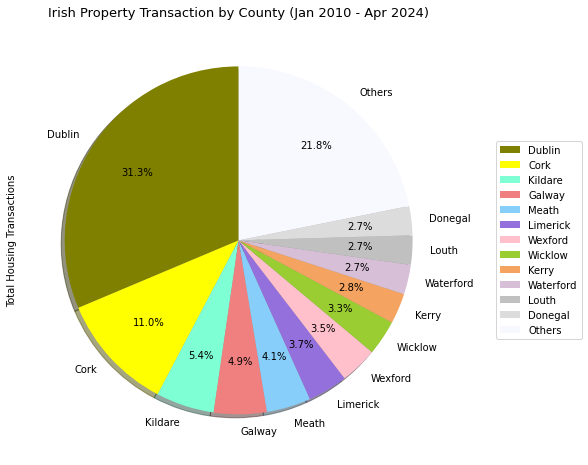

In [8]:
import matplotlib.pyplot as plt
colors_list = ['olive','yellow', 'aquamarine', 'lightcoral', 'lightskyblue', 'mediumpurple', 'pink', 'yellowgreen','sandybrown', 'thistle', 'silver','gainsboro', 'ghostwhite',]
# colors_list = ['olive', 'royalblue', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'olive','sandybrown', 'thistle', 'silver','gainsboro', 'ghostwhite', 'yellowgreen',]

df_volume_top12_others[column_name].plot(kind='pie', figsize=(18,8), pctdistance=0.7, startangle=90,autopct='%1.1f%%' , colors=colors_list, shadow=True,) # , colors=colors_list
plt.legend(labels=df_volume_top12_others.index, bbox_to_anchor=(1.3,0.5),loc='center right')
plt.title("Irish Property Transaction by County (Jan 2010 - Apr 2024)", fontsize=13)
plt.show()

#### Second Figure: "Housing Market Trends: Price vs Transactions (Jan 2011- Apr 2024)"


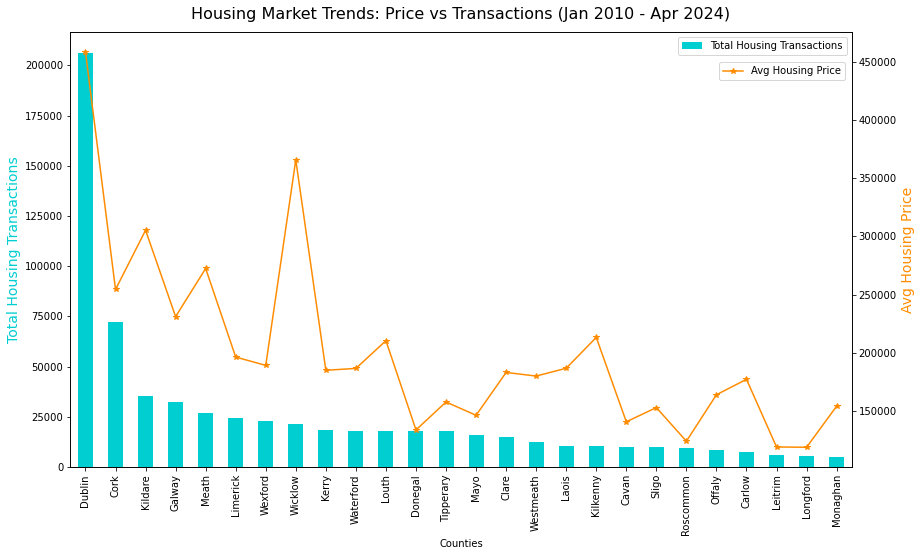

In [9]:
counties_everage_price = {}
for county in counties_list:
    avg_price = round((df[df['County']==county]['Price (Euro)']).mean(), 2)
    counties_everage_price[county] = avg_price
counties_everage_price = dict(sorted(counties_everage_price.items(), key=lambda x:x[1], reverse = True))
counties_everage_price_dataframe = pd.DataFrame.from_dict(counties_everage_price, orient='index')
column_name1 = 'Avg Housing Price'
counties_everage_price_dataframe.rename(columns={0:column_name1}, inplace= True)
# print(counties_everage_price_dataframe)
idx_name='Counties'
counties_everage_price_dataframe.index.name=idx_name
counties_units_sold_dataframe.index.name=idx_name
Avg_price_vs_total_transactions_volumes = counties_units_sold_dataframe.merge(counties_everage_price_dataframe, left_on=idx_name, right_on=idx_name)
Avg_price_vs_total_transactions_volumes.reset_index(inplace=True)
# print(Avg_price_vs_total_transactions_volumes)

c2 = 'darkorange'
c1= 'darkturquoise'
ax1 = Avg_price_vs_total_transactions_volumes.plot(x='Counties', kind='bar',y='Total Housing Transactions', figsize=(14,8), color=c1)
ax1.set_ylabel('Total Housing Transactions', color=c1, fontsize=14)
ax2 = ax1.twinx()
Avg_price_vs_total_transactions_volumes.plot(x='Counties', y='Avg Housing Price', kind='line',linestyle='-', marker='*', ax=ax2, color=c2)
ax2.set_ylabel('Avg Housing Price', color=c2, fontsize=14)
plt.xticks(rotation=90, fontsize=14)
ax1.legend(loc='upper right')
ax2.legend(loc=(0.83,0.89))
plt.title("Housing Market Trends: Price vs Transactions (Jan 2010 - Apr 2024)", fontsize=16, pad=13)
plt.show()

### Third Figure: Irish Monthly Average Housing Prices by County (Jan 2010 - Apr 2024)

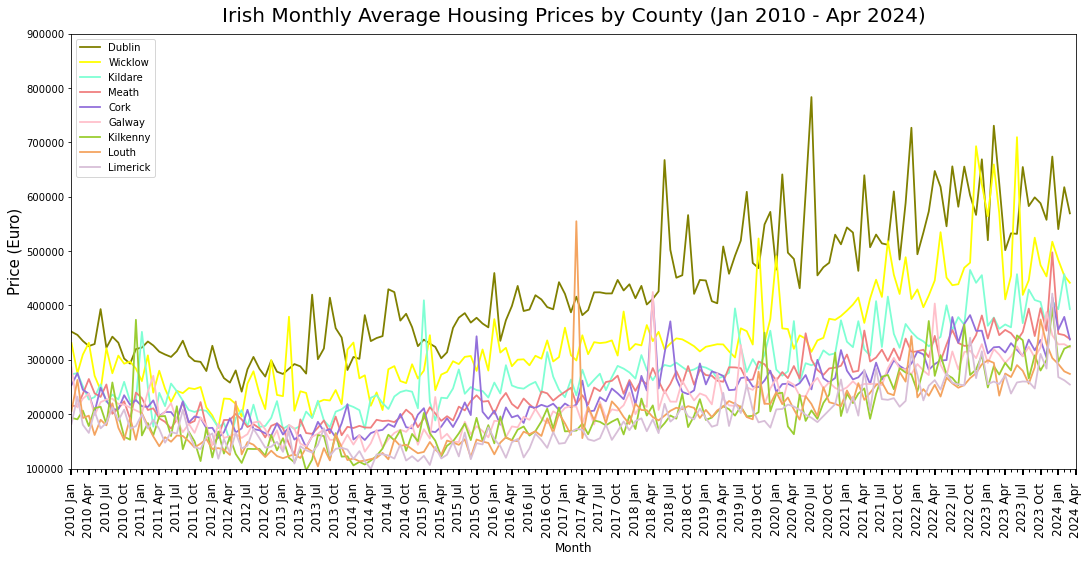

In [10]:
selected_counties = ['Dublin','Wicklow','Kildare', 'Meath', 'Cork','Galway','Kilkenny','Louth','Limerick']
colors_list = ['olive','yellow', 'aquamarine', 'lightcoral', 'mediumpurple', 'pink', 'yellowgreen','sandybrown', 'thistle', 'silver','gainsboro', 'ghostwhite','lightskyblue']

colors_lines = colors_list[:len(selected_counties)]
df_new = df.copy()
df_new['Sales by Year and Month'] = df_new['Date of Sale (yyyy-mm-dd)'].dt.to_period('M')  # Group the data by months
fig, ax = plt.subplots(figsize=(18, 8))
for color, county in zip(colors_lines, selected_counties):
    df_monthly_price = df_new[df_new['County'] == county].groupby('Sales by Year and Month').mean()
    df_monthly_price = df_monthly_price.iloc[:-1, :]
    ax.plot(df_monthly_price.index.to_timestamp(), df_monthly_price['Price (Euro)'], label=county, linewidth=1.8, color = color)

start_date = pd.Timestamp('2010-01')
end_date = pd.Timestamp('2024-04')
ax.set_xlim(start_date, end_date)
ax.set_ylim(100000, 900000)

ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_minor_locator(MonthLocator())
# Format the major ticks' labels
ax.xaxis.set_major_formatter(DateFormatter('%Y %b'))
# Customize tick parameters for major ticks
ax.tick_params(axis='x', which='major', length=6, width=2, labelsize='large', pad=8, rotation=90)
# Customize tick parameters for minor ticks
ax.tick_params(axis='x', which='minor', length=3, width=1, labelsize='small', pad=4)

# Set labels and title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Price (Euro)', fontsize=15)
ax.set_title(f'Irish Monthly Average Housing Prices by County (Jan 2010 - Apr 2024)', fontsize=20, pad=12)
ax.legend()
plt.show()

### Forth Figure: Monthly Average Housing Prices vs Total Houses Sold by County (Jan 2011 - Apr 2024)

In [11]:
def PlotMontlyAveragePriceVsHousesSold(dataframe, county, color_list):
    df_new = dataframe.copy()
    df_new['Sales by Year and Month'] = df_new['Date of Sale (yyyy-mm-dd)'].dt.to_period('M')  # Group the data by months
    df_monthly_price = df_new[df_new['County'] == county].groupby('Sales by Year and Month').mean()
#     df_monthly_price = df_monthly_price.iloc[:-1, :]  # Latest Run the data is completed already
    df_monthly_sales = df_new[df_new['County'] == county].groupby('Sales by Year and Month').count()[['Date of Sale (yyyy-mm-dd)']]
#     df_monthly_sales = df_monthly_sales.iloc[:-1, :]  # The last month data is not complete, so we exclude it.

    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.dates import MonthLocator, YearLocator, DateFormatter

    # Plot the data
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.plot(df_monthly_price.index.to_timestamp(), df_monthly_price['Price (Euro)'], color=color_list[0], label='Property Price', linewidth=1.8, marker='.')
    ax2=ax.twinx()
    ax2.plot(df_monthly_price.index.to_timestamp(),df_monthly_sales['Date of Sale (yyyy-mm-dd)'], color=color_list[1], linewidth=1.2, marker='.',linestyle='--', label='Total Sales')

    start_date = pd.Timestamp('2010-01')
    end_date = pd.Timestamp('2024-04')
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(100000, 900000)
    ax2.set_ylim(0, 2400)

    ax.xaxis.set_major_locator(MonthLocator(interval=3))
    ax.xaxis.set_minor_locator(MonthLocator())
    # Format the major ticks' labels
    ax.xaxis.set_major_formatter(DateFormatter('%Y %b'))
    # Customize tick parameters for major ticks
    ax.tick_params(axis='x', which='major', length=6, width=2, labelsize='large', pad=8, rotation=90)
    ax2.tick_params(axis='x', which='major', length=6, width=2, labelsize='large', pad=8, rotation=90)
    # Customize tick parameters for minor ticks
    ax.tick_params(axis='x', which='minor', length=3, width=1, labelsize='small', pad=4)

    # Set labels and title
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Price (Euro)', fontsize=15, color=color_list[0])
    ax2.set_ylabel('Total Houses Sold', fontsize=15, color=color_list[1])
    ax.set_title(f'Monthly Average Housing Prices vs Total Houses Sold in {county} (Jan 2010 - Apr 2024)', fontsize=20, pad=12)
    ax.legend(loc=(0.89, 0.95))
    ax2.legend(loc=(0.908, 0.908))
    plt.show()

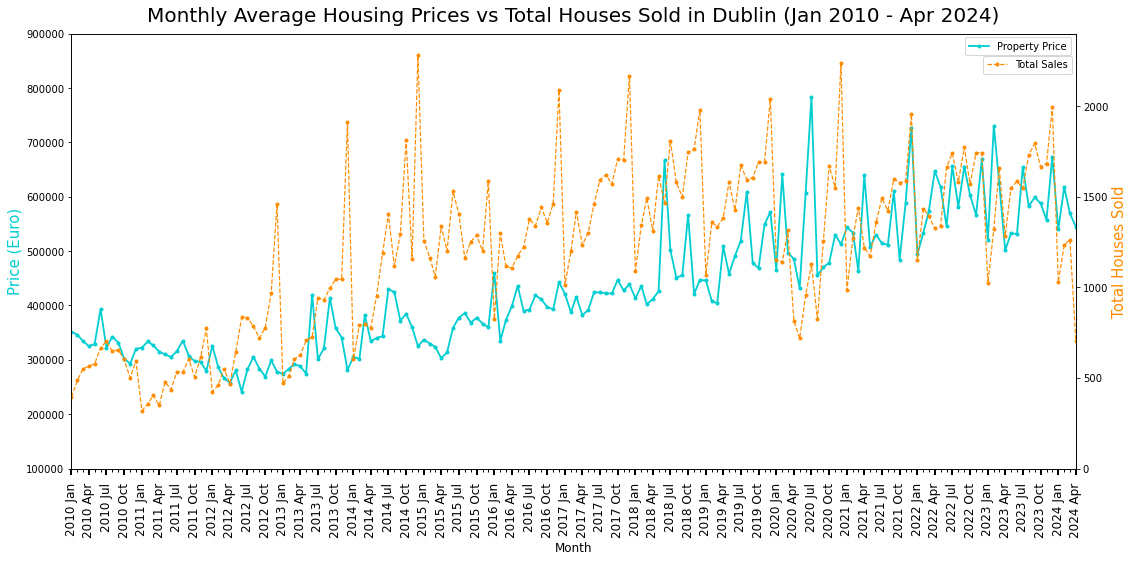

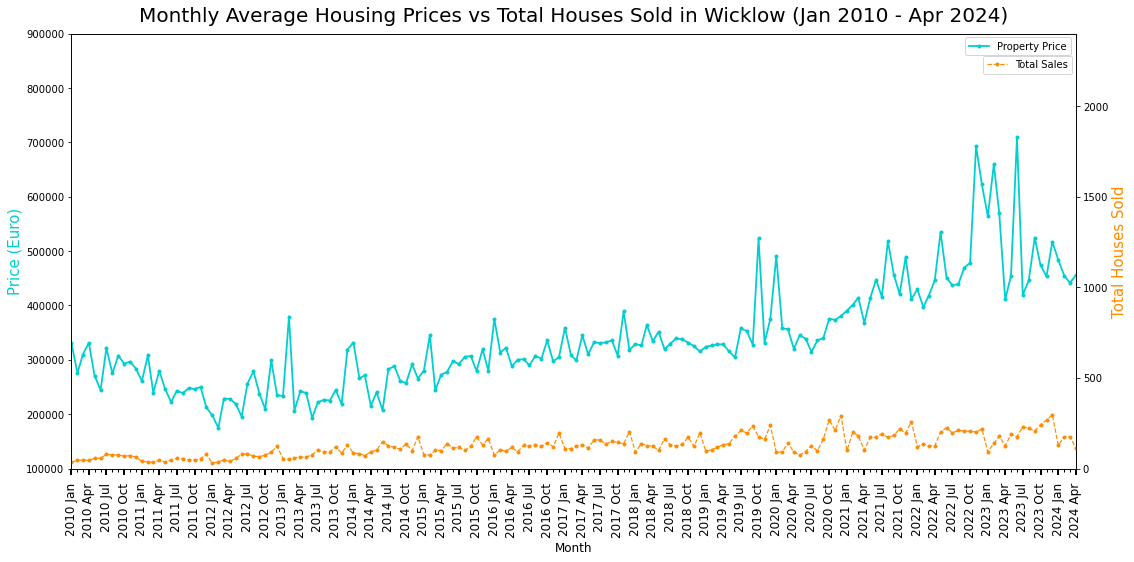

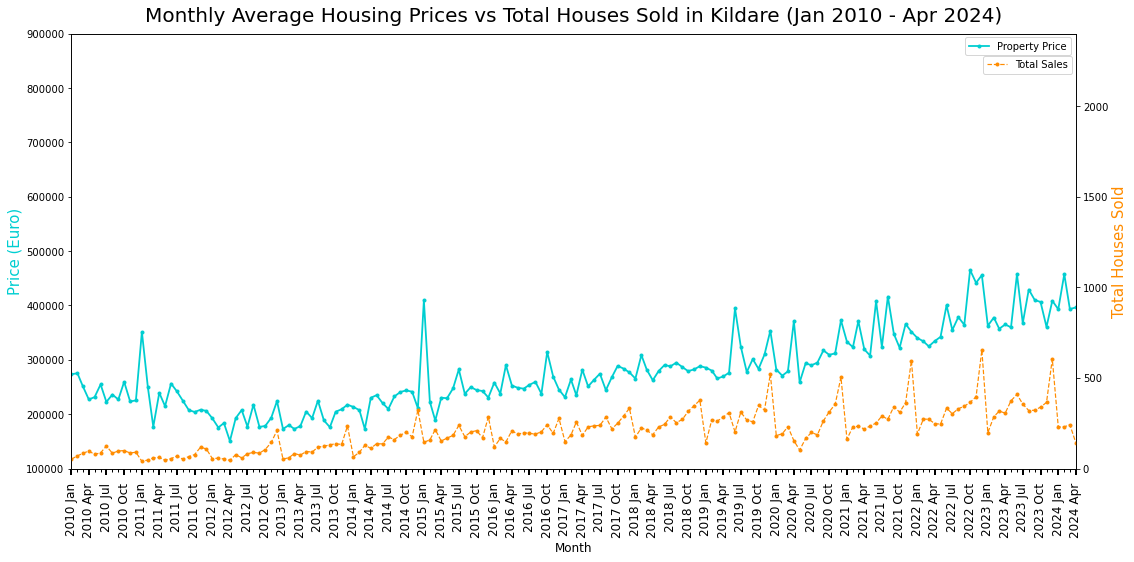

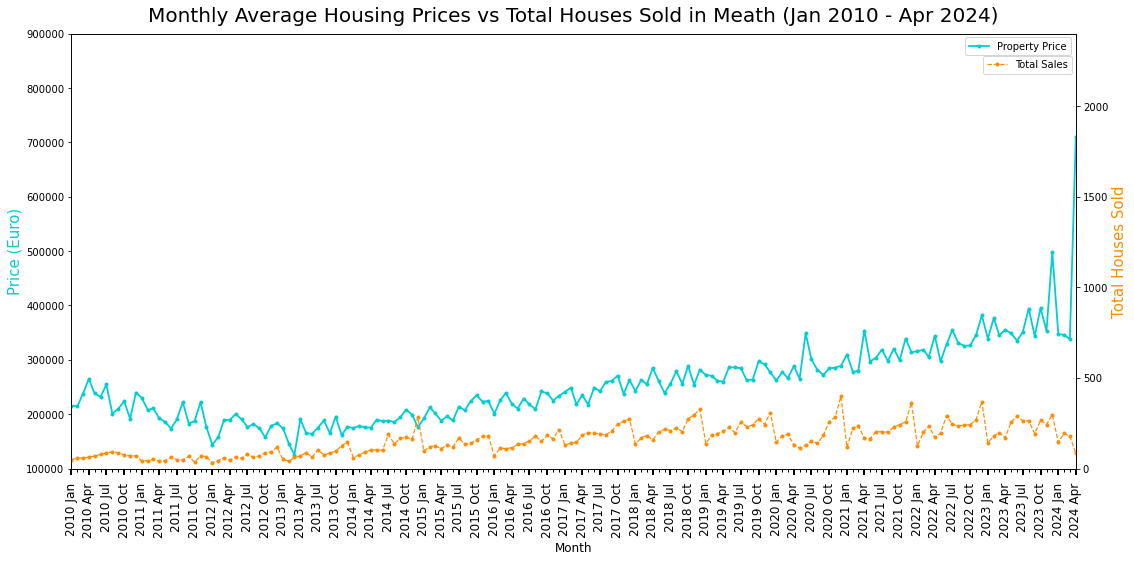

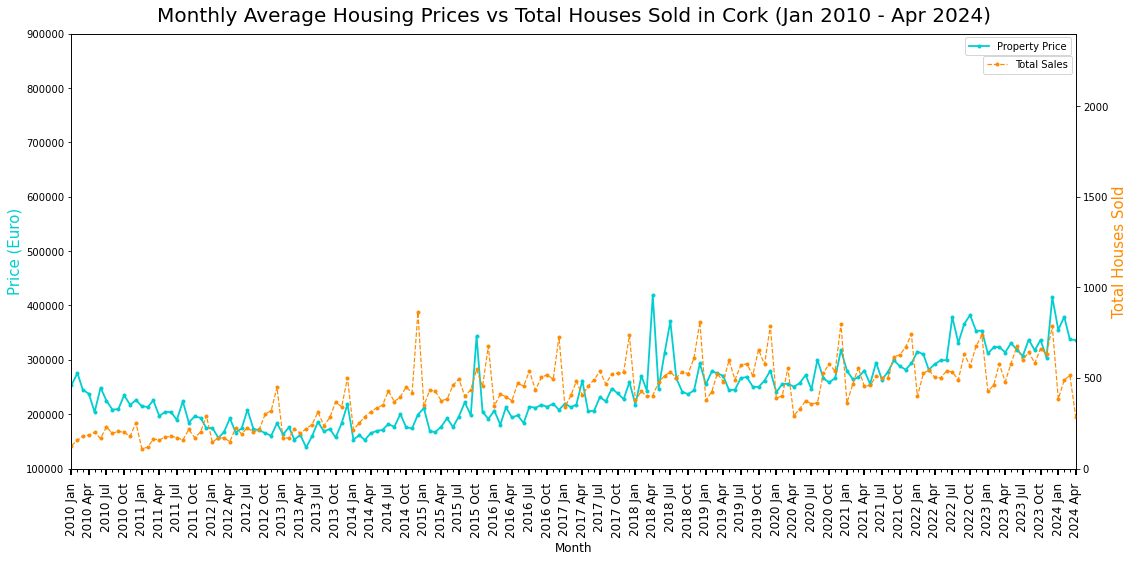

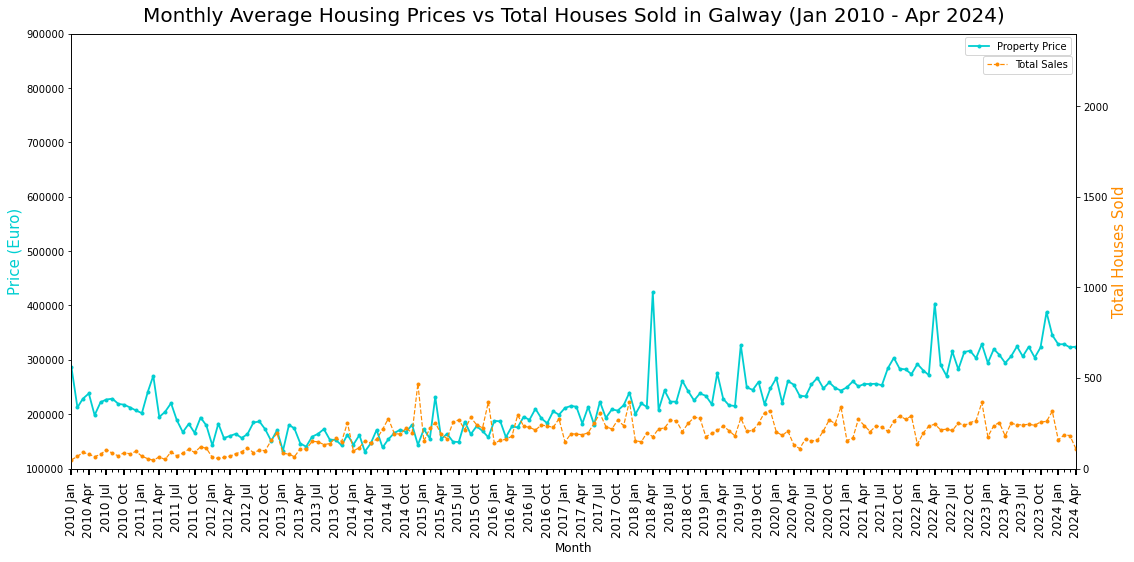

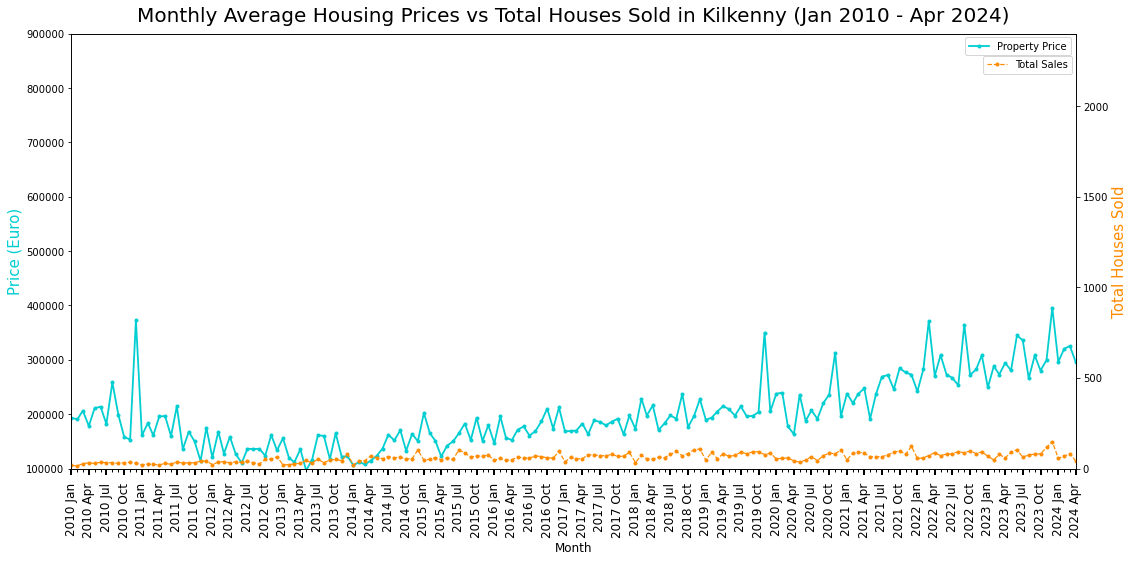

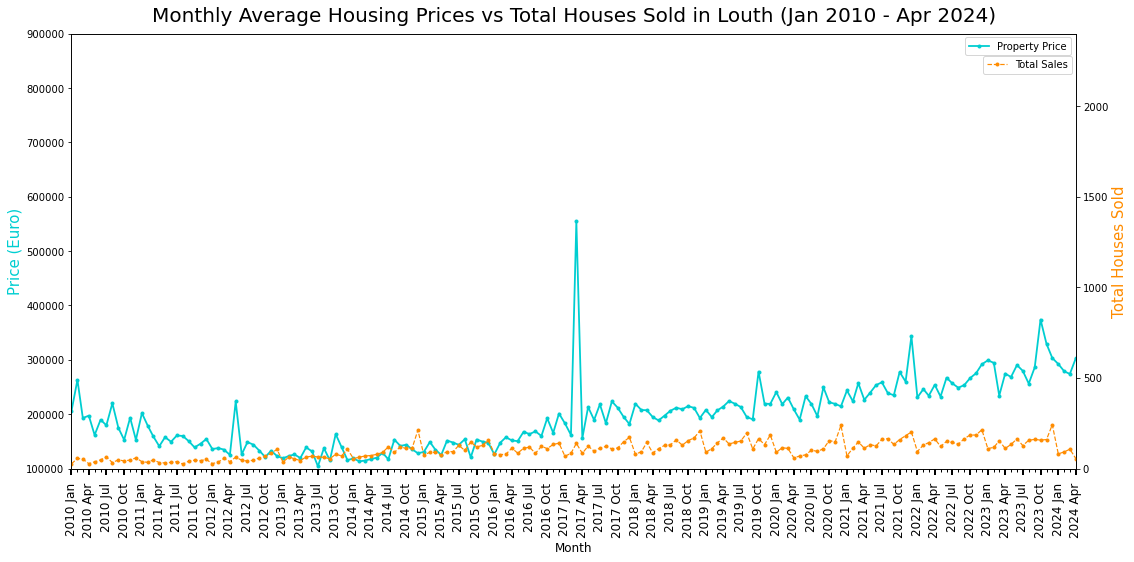

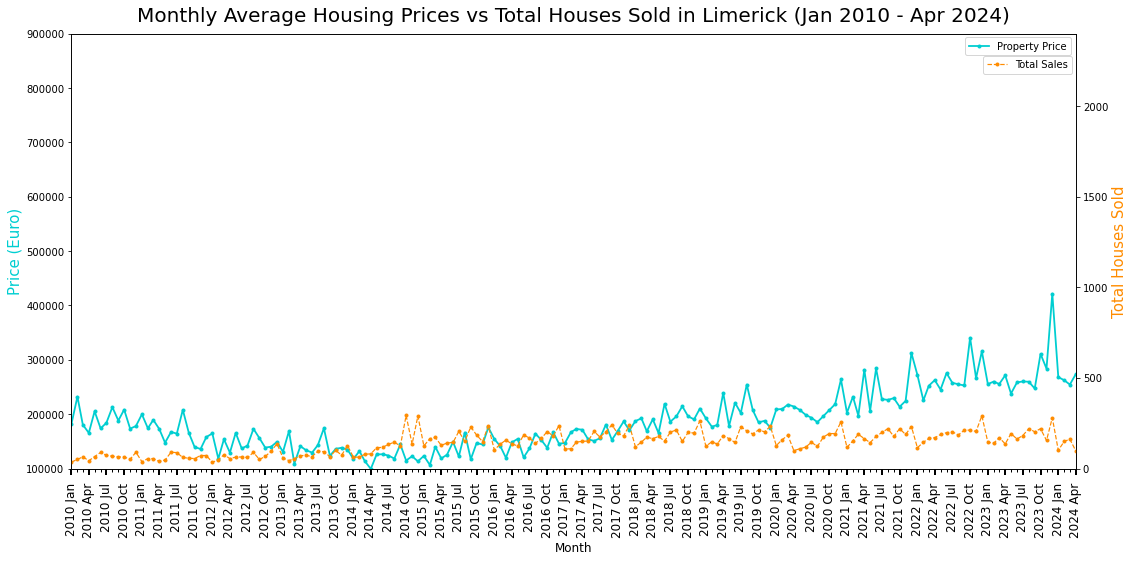

In [12]:
selected_counties = ['Dublin','Wicklow','Kildare', 'Meath', 'Cork','Galway','Kilkenny','Louth','Limerick']
c1= 'darkturquoise'
c2 = 'darkorange'
c3 = 'cornflowerblue'

color_list1 =['seagreen', 'aqua']
color_list2 = [c1,c2]
color_list3 = ['seagreen', c1]
for county in selected_counties:
    PlotMontlyAveragePriceVsHousesSold(df, county, color_list2)

## Step Three: Dublin Housing Price Forecast

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization
from tensorflow.keras import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("cleaned_irish_property.csv" , encoding='unicode_escape', parse_dates=['Date of Sale (yyyy-mm-dd)'], low_memory=False )

In [13]:
df_new = df.copy()
county = 'Dublin'
df_new['Sales by Year and Month'] = df_new['Date of Sale (yyyy-mm-dd)'].dt.to_period('M')  # Group the data by months
df_monthly_dublin = df_new[df_new['County'] == county]
df_monthly_price_Dublin = df_monthly_dublin[['Sales by Year and Month', 'Price (Euro)']].groupby('Sales by Year and Month').mean()
# df_monthly_price_Dublin = df_monthly_price_Dublin.iloc[:-1, :]  # Last run the April data is completed, so do not exclude the last month

### Functions for Data Preprocessing and Model Training

In [8]:
# use Tensorflow Dataset objects to prepare forecast and training datasets. 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size + 1))
    data = data.map(lambda window: (window[:-1], window[-1]))
    # data = data.shuffle(shuffle_buffer)
    data = data.batch(batch_size).prefetch(1)
    return data

def Model_Training(model, train_dataset, epochs=100, learning_rate = 1e-3, patience = 6):
    tf.keras.backend.clear_session()  
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=patience)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae", 'mape','mse'])
    
    # Train the model
    history = model.fit(train_dataset,epochs=epochs, callbacks=[callback])
    plt.plot(history.history['loss'])
    return model

# use Tensorflow Dataset objects to prepare forecast datasets.
def Model_Forecast(model, forecast_serie, window_size, batch_size):
    data = tf.data.Dataset.from_tensor_slices(forecast_serie )
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(batch_size).prefetch(1)
    forecast_results = model.predict(data)
    return forecast_results

def Model_Evaluate(model, valid_data, forecast_results):
    print(f'Mean Absolute Error is: {tf.keras.metrics.mean_absolute_error(valid_data, forecast_results).numpy()}')
    print(f'Mean Squared Error is: {tf.keras.metrics.mean_squared_error(valid_data, forecast_results).numpy()}')
    print(f'Mean Absolute Percentage Error is:{tf.keras.metrics.mean_absolute_percentage_error(valid_data, forecast_results).numpy()}')

### Preprocessing Monthly Data

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_monthly_price_Dublin)

In [20]:
time_stamp = int(df_monthly_price_Dublin.shape[0]*0.85) # 146
monthly_series_dublin_training = scaled_data[:time_stamp]
# len(monthly_series_dublin_training) # 146

In [14]:
df_monthly_price_Dublin

,Price (Euro)
Sales by Year and Month,
2010-01,351785.311367
2010-02,345820.755782
2010-03,334785.282745
2010-04,325239.026915
2010-05,329119.002370
...,...
2023-12,673911.744975
2024-01,540418.180836
2024-02,617577.413333


In [21]:
window_size = 12
monthly_series_dublin_training = scaled_data[:time_stamp]
monthly_series_dublin_validation = df_monthly_price_Dublin.iloc[time_stamp:, -1].to_numpy()
monthly_series_dublin_forecast = scaled_data[time_stamp-window_size:-1]
time_series = df_monthly_price_Dublin.index.to_timestamp().to_numpy()
time_train = time_series[:time_stamp]
time_valid = time_series[time_stamp:]

#### Best model architecture among experimentation
On average, the below architecture achieves the lowest mean absolute percentage errors.

In [24]:
model = tf.keras.Sequential([
    LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
    Dropout(0.5),
    LayerNormalization(),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu' ),   
    Dense(1)
    ])

2024-05-02 20:40:37.795893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2024-05-02 20:40:37.961250: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [48]:
# # Some of the experimented architectures are demonstrated below. 

# model = tf.keras.Sequential([
#     LSTM(128, activation='relu', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.8),
#     LSTM(32),
#     Dense(1)
# ])
# # 16.319595336914062

# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.8),
#     LSTM(32),
#     Dense(1)
# ])
# # 10

# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.4),
#     LSTM(32),
#     Dense(1)
# ])
# # 11

# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='tanh'),
#     # Dropout(0.5),
#     Dense(32),
#     Dense(1)
# ])
# # 11.658 without last dropout, set dropout to 0.5
# # Mean Absolute Percentage Error is:9.136388778686523
# # 23.26  without last dropout, set dropout to 0.3
# # 12.280 with two dropout layers after LSTM set to 0.5


# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='tanh'),
#     # Dropout(0.5),
#     Dense(32, activation='relu' ),
#     Dense(1)
# ])
# # Mean Absolute Percentage Error is:17.745811462402344, first 'relu', second 'tanh'
# # 20, first 'tanh', second 'relu'
# # 10.796245574951172 both 'tanh' 
# # 16.4490966796875 both 'tanh' with extra dropout

# ## Another Normalization layers, best until 17:10pm
# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, activation='tanh'),
#     Dense(32, activation='relu' ),
#     LayerNormalization(),
#     Dense(1)
#     ])
# # Mean Absolute Percentage Error is:7.957189559936523
# # Mean Absolute Percentage Error is:8.266759872436523
# # Mean Absolute Percentage Error is:9.590702056884766

# model = tf.keras.Sequential([
#     LSTM(128, activation='tanh', input_shape=(window_size, 1), return_sequences=True),
#     Dropout(0.5),
#     LayerNormalization(),
#     LSTM(64, activation='tanh'),
#     Dropout(0.3),
#     LayerNormalization(),
#     Dense(32, activation='relu' ),   
#     Dense(1)
#     ])
# # Mean Absolute Percentage Error is:7.839635848999023
# # reduce second drop out : Mean Absolute Percentage Error is:8.448091506958008

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=12, kernel_size=3, strides=1, activation='relu', padding = 'causal', input_shape = [window_size, 1]),
#     tf.keras.layers.LSTM(12, return_sequences=True),
#     tf.keras.layers.LSTM(12),
#     tf.keras.layers.Dense(12, activation="relu"),
#     tf.keras.layers.Dense(6, activation="relu"),
#     tf.keras.layers.Dense(1)
# ])

#### Model Training

In [26]:
window_size = 12
batch_size = 12
shuffle_buffer_size = 200
train_dataset = windowed_dataset(monthly_series_dublin_training, window_size, batch_size, shuffle_buffer_size)
# next(iter(train_dataset.take(1)))

Epoch 1/100


2024-05-02 20:41:29.380600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


      1/Unknown - 2s 2s/step - loss: 0.0827 - mae: 0.4001 - mape: 319.0092 - mse: 0.1654

2024-05-02 20:41:30.146311: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f047c0cae70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-02 20:41:30.146367: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
I0000 00:00:1714675290.180672  444192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 3s 9ms/step - loss: 0.0269 - mae: 0.1792 - mape: 808019.1250 - mse: 0.0538
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1038 - mae: 0.3861 - mape: 6035405.0000 - mse: 0.2075
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0140 - mae: 0.1398 - mape: 121124.0703 - mse: 0.0280
Epoch 4/100


2024-05-02 20:41:30.411815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1985297258540160546


12/12 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.1456 - mape: 2055116.6250 - mse: 0.0339
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0136 - mae: 0.1133 - mape: 486640.3438 - mse: 0.0271
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0941 - mape: 536282.1250 - mse: 0.0161
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0072 - mae: 0.0890 - mape: 81959.3203 - mse: 0.0144
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0084 - mae: 0.0968 - mape: 716988.8125 - mse: 0.0167
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0069 - mae: 0.0867 - mape: 1063520.2500 - mse: 0.0137
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0085 - mae: 0.0920 - mape: 612211.3750 - mse: 0.0171
Epoch 11/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0084 - mae: 0.0900 - mape: 701434.8750

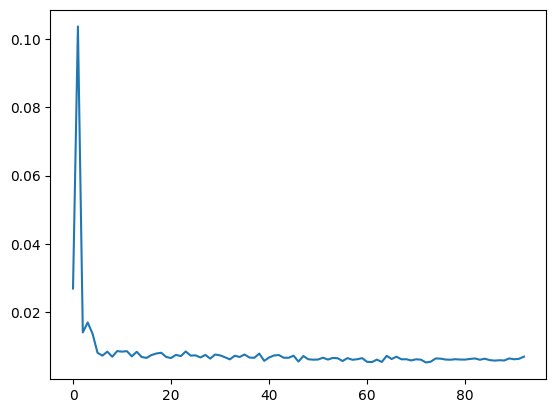

In [27]:
model = Model_Training(model, train_dataset, patience=20) # epochs=200

In [29]:
forecast_results = Model_Forecast(model, monthly_series_dublin_forecast, window_size, batch_size)
reversed_forecast_results = scaler.inverse_transform(forecast_results)
reversed_forecast_results=reversed_forecast_results.squeeze()
Model_Evaluate(model, monthly_series_dublin_validation, reversed_forecast_results)

3/3 [==============================] - 0s 6ms/step
Mean Absolute Error is: 46518.75390625
Mean Squared Error is: 3158162176.0
Mean Absolute Percentage Error is:7.800769805908203


2024-05-02 20:45:24.798341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15390147103672965406


#### Plot the chart 

In [30]:
forecast_whole = Model_Forecast(model, scaled_data , window_size, batch_size)
reversed_forecast_whole = scaler.inverse_transform(forecast_whole)
reversed_forecast_whole = reversed_forecast_whole.squeeze()

14/14 [==============================] - 0s 2ms/step


2024-05-02 20:46:26.780497: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15390147103672965406


In [38]:
import datetime
from dateutil.relativedelta import relativedelta
time_whole = time_series[window_size:]
validation_whole=df_monthly_price_Dublin.iloc[window_size:, -1]
last_month = df_monthly_price_Dublin.index[-1].to_timestamp()
next_month = last_month + relativedelta(months=1)
forward_period = [last_month, next_month]
forward_predict = reversed_forecast_whole [-2:]

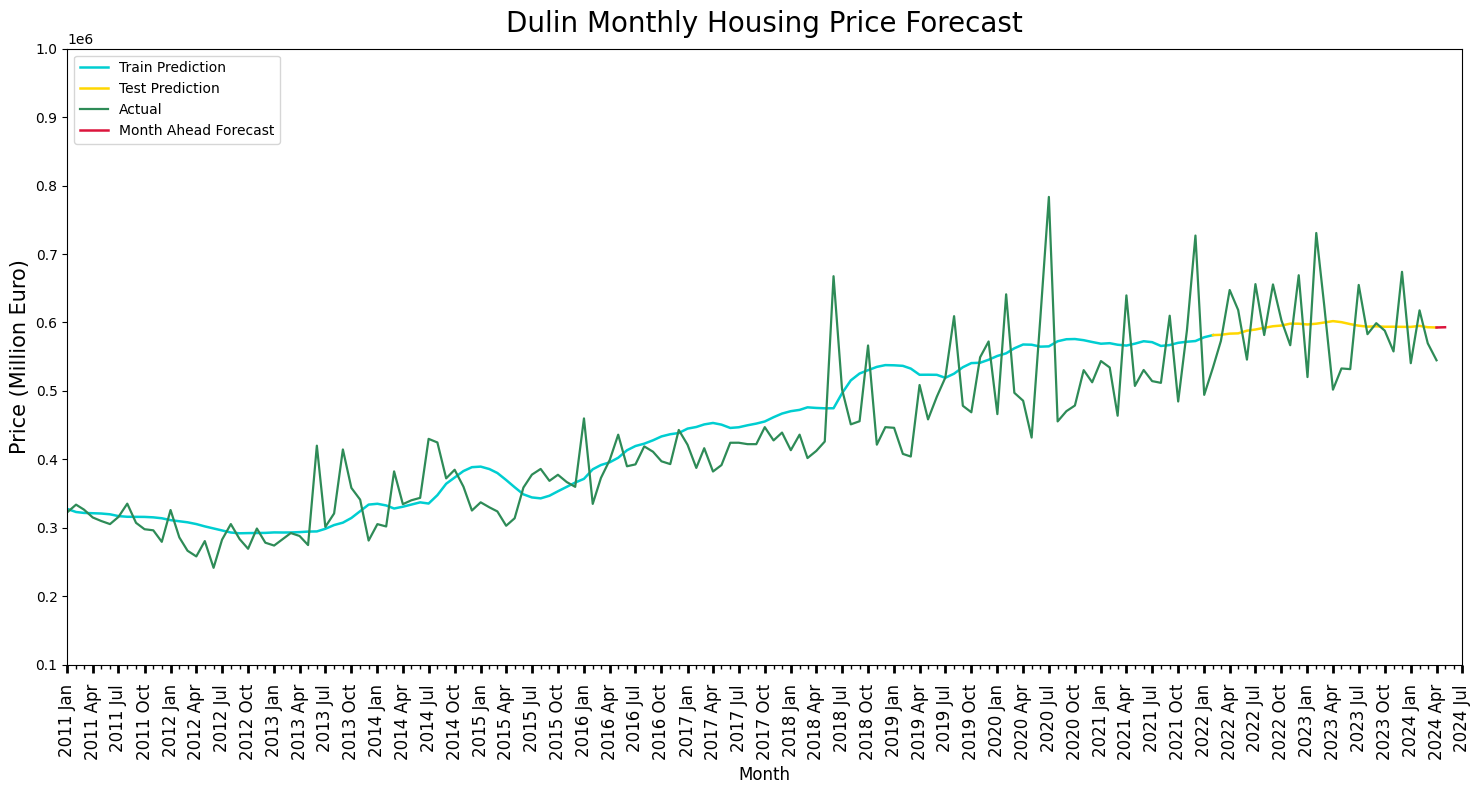

In [41]:
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(time_series[window_size:time_stamp], reversed_forecast_whole[:time_stamp-window_size], color='darkturquoise', label = 'Train Prediction', linewidth=1.8)
ax.plot(time_series[time_stamp-1:], reversed_forecast_whole[time_stamp-window_size-1:-1], color='gold', label = 'Test Prediction', linewidth=1.8)
ax.plot(time_whole, validation_whole, color='seagreen', label = 'Actual', linewidth=1.6)
ax.plot(forward_period, forward_predict, color='crimson', label = 'Month Ahead Forecast', linewidth=1.8)
ax.legend(loc='upper left')
plt.ylim(100000, 1000000)

ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_minor_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y %b'))

ax.tick_params(axis='x', which='major', length=6, width=2, labelsize='large', pad=8, rotation=90)
ax.tick_params(axis='x', which='minor', length=3, width=1, labelsize='small', pad=4)

ax.xaxis.set_major_formatter(DateFormatter('%Y %b'))

start_date = pd.Timestamp('2011-01')
end_date = pd.Timestamp('2024-07')
ax.set_xlim(start_date, end_date)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Price (Million Euro)', fontsize=15)
plt.title('Dulin Monthly Housing Price Forecast', fontsize=20, pad=12)
plt.show()

In [52]:
Model_Evaluate(model, monthly_series_dublin_validation, reversed_forecast_results)
print(f'The forecasted Dublin Housing price for the month ahead (May 2024) is {reversed_forecast_whole[-1]:.2f} euros')

Mean Absolute Error is: 46518.75390625
Mean Squared Error is: 3158162176.0
Mean Absolute Percentage Error is:7.800769805908203
The forecasted Dublin Housing price for the month ahead (May 2024) is 592928.31 euros
